# NBA PREDICTION

In [1]:
#load packages
import pandas as pd #collection of functions for data processing and analysis
import matplotlib #collectionbb of functions for scientific and publication-ready visualization
import numpy as np #foundational package for scientific computing
import sqlite3

#misc libraries
import time
import warnings
warnings.filterwarnings('ignore') #ignore warnings

#model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

#model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.feature_selection import RFECV
from yellowbrick.features import RFECV as RFE
from sklearn import model_selection
from sklearn import metrics

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#visualization defaults
%matplotlib inline 
#show plots in Jupyter Notebook browser
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#pandas defaults
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

### LOAD DATA

In [2]:
# create sqlite connection
PATH = 'C:/data/'
conn = sqlite3.connect(PATH + 'nba.sqlite')

# load tables
stats_ytd = pd.read_sql_query("SELECT * FROM stats_ytd", conn)
stats_last7 = pd.read_sql_query("SELECT * FROM stats_last7", conn)
stats_ytd_field = pd.read_sql_query("SELECT * FROM stats_ytd_field", conn)
stats_last7_field = pd.read_sql_query("SELECT * FROM stats_last7_field", conn)
overview = pd.read_sql_query("SELECT * FROM overview", conn)
odds = pd.read_sql_query("SELECT * FROM odds", conn)
results = pd.read_sql_query("SELECT * FROM results", conn)
teams = pd.read_sql_query("SELECT * FROM teams", conn)
conn.close()

In [3]:
# join results
results_joined = pd.merge(results, results, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
results_joined = results_joined[results_joined['field_home'] == 'home']
results_joined = results_joined[results_joined['field_home'] != results_joined['field_away']]
results_joined.head(5)

,match_id,season_home,type_home,date_home,team_id_home,field_home,score_home,win_home,spread_home,season_away,type_away,date_away,team_id_away,field_away,score_away,win_away,spread_away
2,1,2003-2004,Season,2003-10-28,14,home,109,1,16,2003-2004,Season,2003-10-28,7,away,93,0,-16
6,2,2003-2004,Season,2003-10-28,23,home,89,1,15,2003-2004,Season,2003-10-28,16,away,74,0,-15
10,3,2003-2004,Season,2003-10-28,27,home,83,1,1,2003-2004,Season,2003-10-28,24,away,82,0,-1
13,4,2003-2004,Season,2003-10-29,2,home,98,1,23,2003-2004,Season,2003-10-29,16,away,75,0,-23
17,5,2003-2004,Season,2003-10-29,5,home,74,0,-25,2003-2004,Season,2003-10-29,30,away,99,1,25


In [4]:
# join stats ytd
stats_ytd_joined = pd.merge(stats_ytd, stats_ytd, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
stats_ytd_joined = stats_ytd_joined[stats_ytd_joined['team_id_home'] != stats_ytd_joined['team_id_away']]
stats_ytd_joined = stats_ytd_joined.add_suffix('_ytd')
stats_ytd_joined = stats_ytd_joined.rename(index=str, columns={"match_id_ytd": "match_id", "team_id_home_ytd": 
                                                               "team_id_home", "team_id_away_ytd": "team_id_away"})
stats_ytd_joined.head(5)

,match_id,team_id_home,2p_home_ytd,2p_perc_home_ytd,2pa_home_ytd,2par_perc_home_ytd,3p_home_ytd,3p_perc_home_ytd,3pa_home_ytd,3par_perc_home_ytd,ast_home_ytd,ast_perc_home_ytd,ast_tov_perc_home_ytd,blk_home_ytd,blk_perc_home_ytd,dr_home_ytd,drb_home_ytd,drb_perc_home_ytd,drb_trb_perc_home_ytd,efg_perc_home_ytd,fg_home_ytd,fg_perc_home_ytd,fga_home_ytd,fic_home_ytd,ft_home_ytd,ft_fga_perc_home_ytd,ft_perc_home_ytd,fta_home_ytd,ftar_perc_home_ytd,hob_perc_home_ytd,or_home_ytd,orb_home_ytd,orb_perc_home_ytd,orb_trb_perc_home_ytd,ot_home_ytd,pf_home_ytd,plus_minus_home_ytd,points_1p_home_ytd,points_2p_home_ytd,points_3p_home_ytd,points_4p_home_ytd,points_ot_home_ytd,pts_home_ytd,stl_home_ytd,stl_perc_home_ytd,stl_tov_perc_home_ytd,tov_home_ytd,tov_perc_home_ytd,trb_home_ytd,trb_perc_home_ytd,ts_perc_home_ytd,tsa_home_ytd,opp_2p_home_ytd,opp_2p_perc_home_ytd,opp_2pa_home_ytd,opp_2par_perc_home_ytd,opp_3p_home_ytd,opp_3p_perc_home_ytd,opp_3pa_home_ytd,opp_3par_perc_home_ytd,opp_ast_home_ytd,opp_ast_perc_home_ytd,opp_ast_tov_perc_home_ytd,opp_blk_home_ytd,opp_blk_perc_home_ytd,opp_dr_home_ytd,opp_drb_home_ytd,opp_drb_perc_home_ytd,opp_drb_trb_perc_home_ytd,opp_efg_perc_home_ytd,opp_fg_home_ytd,opp_fg_perc_home_ytd,opp_fga_home_ytd,opp_fic_home_ytd,opp_ft_home_ytd,opp_ft_fga_perc_home_ytd,opp_ft_perc_home_ytd,opp_fta_home_ytd,opp_ftar_perc_home_ytd,opp_hob_perc_home_ytd,opp_or_home_ytd,opp_orb_home_ytd,opp_orb_perc_home_ytd,opp_orb_trb_perc_home_ytd,opp_ot_home_ytd,opp_pf_home_ytd,opp_plus_minus_home_ytd,opp_points_1p_home_ytd,opp_points_2p_home_ytd,opp_points_3p_home_ytd,opp_points_4p_home_ytd,opp_points_ot_home_ytd,opp_pts_home_ytd,opp_stl_home_ytd,opp_stl_perc_home_ytd,opp_stl_tov_perc_home_ytd,opp_tov_home_ytd,opp_tov_perc_home_ytd,opp_trb_home_ytd,opp_trb_perc_home_ytd,opp_ts_perc_home_ytd,opp_tsa_home_ytd,team_id_away,2p_away_ytd,2p_perc_away_ytd,2pa_away_ytd,2par_perc_away_ytd,3p_away_ytd,3p_perc_away_ytd,3pa_away_ytd,3par_perc_away_ytd,ast_away_ytd,ast_perc_away_ytd,ast_tov_perc_away_ytd,blk_away_ytd,blk_perc_away_ytd,dr_away_ytd,drb_away_ytd,drb_perc_away_ytd,drb_trb_perc_away_ytd,efg_perc_away_ytd,fg_away_ytd,fg_perc_away_ytd,fga_away_ytd,fic_away_ytd,ft_away_ytd,ft_fga_perc_away_ytd,ft_perc_away_ytd,fta_away_ytd,ftar_perc_away_ytd,hob_perc_away_ytd,or_away_ytd,orb_away_ytd,orb_perc_away_ytd,orb_trb_perc_away_ytd,ot_away_ytd,pf_away_ytd,plus_minus_away_ytd,points_1p_away_ytd,points_2p_away_ytd,points_3p_away_ytd,points_4p_away_ytd,points_ot_away_ytd,pts_away_ytd,stl_away_ytd,stl_perc_away_ytd,stl_tov_perc_away_ytd,tov_away_ytd,tov_perc_away_ytd,trb_away_ytd,trb_perc_away_ytd,ts_perc_away_ytd,tsa_away_ytd,opp_2p_away_ytd,opp_2p_perc_away_ytd,opp_2pa_away_ytd,opp_2par_perc_away_ytd,opp_3p_away_ytd,opp_3p_perc_away_ytd,opp_3pa_away_ytd,opp_3par_perc_away_ytd,opp_ast_away_ytd,opp_ast_perc_away_ytd,opp_ast_tov_perc_away_ytd,opp_blk_away_ytd,opp_blk_perc_away_ytd,opp_dr_away_ytd,opp_drb_away_ytd,opp_drb_perc_away_ytd,opp_drb_trb_perc_away_ytd,opp_efg_perc_away_ytd,opp_fg_away_ytd,opp_fg_perc_away_ytd,opp_fga_away_ytd,opp_fic_away_ytd,opp_ft_away_ytd,opp_ft_fga_perc_away_ytd,opp_ft_perc_away_ytd,opp_fta_away_ytd,opp_ftar_perc_away_ytd,opp_hob_perc_away_ytd,opp_or_away_ytd,opp_orb_away_ytd,opp_orb_perc_away_ytd,opp_orb_trb_perc_away_ytd,opp_ot_away_ytd,opp_pf_away_ytd,opp_plus_minus_away_ytd,opp_points_1p_away_ytd,opp_points_2p_away_ytd,opp_points_3p_away_ytd,opp_points_4p_away_ytd,opp_points_ot_away_ytd,opp_pts_away_ytd,opp_stl_away_ytd,opp_stl_perc_away_ytd,opp_stl_tov_perc_away_ytd,opp_tov_away_ytd,opp_tov_perc_away_ytd,opp_trb_away_ytd,opp_trb_perc_away_ytd,opp_ts_perc_away_ytd,opp_tsa_away_ytd
1,1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [5]:
# join stats ytd field
stats_ytd_field_joined = pd.merge(stats_ytd_field, stats_ytd_field, on='match_id', how='inner', suffixes=("_home","_away"))
# join cleaning
stats_ytd_field_joined = stats_ytd_field_joined[stats_ytd_field_joined['team_id_home'] != stats_ytd_field_joined['team_id_away']]
stats_ytd_field_joined = stats_ytd_field_joined.add_suffix('_ytd_field')
stats_ytd_field_joined = stats_ytd_field_joined.rename(index=str, columns={"match_id_ytd_field": "match_id", "team_id_home_ytd_field": 
                                                               "team_id_home", "team_id_away_ytd_field": "team_id_away"})
stats_ytd_field_joined.head(5)

,match_id,team_id_home,2p_home_ytd_field,2p_perc_home_ytd_field,2pa_home_ytd_field,2par_perc_home_ytd_field,3p_home_ytd_field,3p_perc_home_ytd_field,3pa_home_ytd_field,3par_perc_home_ytd_field,ast_home_ytd_field,ast_perc_home_ytd_field,ast_tov_perc_home_ytd_field,blk_home_ytd_field,blk_perc_home_ytd_field,dr_home_ytd_field,drb_home_ytd_field,drb_perc_home_ytd_field,drb_trb_perc_home_ytd_field,efg_perc_home_ytd_field,fg_home_ytd_field,fg_perc_home_ytd_field,fga_home_ytd_field,fic_home_ytd_field,ft_home_ytd_field,ft_fga_perc_home_ytd_field,ft_perc_home_ytd_field,fta_home_ytd_field,ftar_perc_home_ytd_field,hob_perc_home_ytd_field,or_home_ytd_field,orb_home_ytd_field,orb_perc_home_ytd_field,orb_trb_perc_home_ytd_field,ot_home_ytd_field,pf_home_ytd_field,plus_minus_home_ytd_field,points_1p_home_ytd_field,points_2p_home_ytd_field,points_3p_home_ytd_field,points_4p_home_ytd_field,points_ot_home_ytd_field,pts_home_ytd_field,stl_home_ytd_field,stl_perc_home_ytd_field,stl_tov_perc_home_ytd_field,tov_home_ytd_field,tov_perc_home_ytd_field,trb_home_ytd_field,trb_perc_home_ytd_field,ts_perc_home_ytd_field,tsa_home_ytd_field,opp_2p_home_ytd_field,opp_2p_perc_home_ytd_field,opp_2pa_home_ytd_field,opp_2par_perc_home_ytd_field,opp_3p_home_ytd_field,opp_3p_perc_home_ytd_field,opp_3pa_home_ytd_field,opp_3par_perc_home_ytd_field,opp_ast_home_ytd_field,opp_ast_perc_home_ytd_field,opp_ast_tov_perc_home_ytd_field,opp_blk_home_ytd_field,opp_blk_perc_home_ytd_field,opp_dr_home_ytd_field,opp_drb_home_ytd_field,opp_drb_perc_home_ytd_field,opp_drb_trb_perc_home_ytd_field,opp_efg_perc_home_ytd_field,opp_fg_home_ytd_field,opp_fg_perc_home_ytd_field,opp_fga_home_ytd_field,opp_fic_home_ytd_field,opp_ft_home_ytd_field,opp_ft_fga_perc_home_ytd_field,opp_ft_perc_home_ytd_field,opp_fta_home_ytd_field,opp_ftar_perc_home_ytd_field,opp_hob_perc_home_ytd_field,opp_or_home_ytd_field,opp_orb_home_ytd_field,opp_orb_perc_home_ytd_field,opp_orb_trb_perc_home_ytd_field,opp_ot_home_ytd_field,opp_pf_home_ytd_field,opp_plus_minus_home_ytd_field,opp_points_1p_home_ytd_field,opp_points_2p_home_ytd_field,opp_points_3p_home_ytd_field,opp_points_4p_home_ytd_field,opp_points_ot_home_ytd_field,opp_pts_home_ytd_field,opp_stl_home_ytd_field,opp_stl_perc_home_ytd_field,opp_stl_tov_perc_home_ytd_field,opp_tov_home_ytd_field,opp_tov_perc_home_ytd_field,opp_trb_home_ytd_field,opp_trb_perc_home_ytd_field,opp_ts_perc_home_ytd_field,opp_tsa_home_ytd_field,team_id_away,2p_away_ytd_field,2p_perc_away_ytd_field,2pa_away_ytd_field,2par_perc_away_ytd_field,3p_away_ytd_field,3p_perc_away_ytd_field,3pa_away_ytd_field,3par_perc_away_ytd_field,ast_away_ytd_field,ast_perc_away_ytd_field,ast_tov_perc_away_ytd_field,blk_away_ytd_field,blk_perc_away_ytd_field,dr_away_ytd_field,drb_away_ytd_field,drb_perc_away_ytd_field,drb_trb_perc_away_ytd_field,efg_perc_away_ytd_field,fg_away_ytd_field,fg_perc_away_ytd_field,fga_away_ytd_field,fic_away_ytd_field,ft_away_ytd_field,ft_fga_perc_away_ytd_field,ft_perc_away_ytd_field,fta_away_ytd_field,ftar_perc_away_ytd_field,hob_perc_away_ytd_field,or_away_ytd_field,orb_away_ytd_field,orb_perc_away_ytd_field,orb_trb_perc_away_ytd_field,ot_away_ytd_field,pf_away_ytd_field,plus_minus_away_ytd_field,points_1p_away_ytd_field,points_2p_away_ytd_field,points_3p_away_ytd_field,points_4p_away_ytd_field,points_ot_away_ytd_field,pts_away_ytd_field,stl_away_ytd_field,stl_perc_away_ytd_field,stl_tov_perc_away_ytd_field,tov_away_ytd_field,tov_perc_away_ytd_field,trb_away_ytd_field,trb_perc_away_ytd_field,ts_perc_away_ytd_field,tsa_away_ytd_field,opp_2p_away_ytd_field,opp_2p_perc_away_ytd_field,opp_2pa_away_ytd_field,opp_2par_perc_away_ytd_field,opp_3p_away_ytd_field,opp_3p_perc_away_ytd_field,opp_3pa_away_ytd_field,opp_3par_perc_away_ytd_field,opp_ast_away_ytd_field,opp_ast_perc_away_ytd_field,opp_ast_tov_perc_away_ytd_field,opp_blk_away_ytd_field,opp_blk_perc_away_ytd_field,opp_dr_away_ytd_field,opp_drb_away_ytd_field,opp_drb_perc_away_ytd_field,opp_drb_trb_perc_away_ytd_field,opp_e

In [6]:
# join stats last 7
stats_last7_joined = pd.merge(stats_last7, stats_last7, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
stats_last7_joined = stats_ytd_joined[stats_ytd_joined['team_id_home'] != stats_ytd_joined['team_id_away']]
stats_last7_joined = stats_last7_joined.add_suffix('_last7')
stats_last7_joined = stats_last7_joined.rename(index=str, columns={"match_id_last7": "match_id", "team_id_home_last7": 
                                                               "team_id_home", "team_id_away_last7": "team_id_away"})
stats_last7_joined.head(5)

,match_id,team_id_home,2p_home_ytd_last7,2p_perc_home_ytd_last7,2pa_home_ytd_last7,2par_perc_home_ytd_last7,3p_home_ytd_last7,3p_perc_home_ytd_last7,3pa_home_ytd_last7,3par_perc_home_ytd_last7,ast_home_ytd_last7,ast_perc_home_ytd_last7,ast_tov_perc_home_ytd_last7,blk_home_ytd_last7,blk_perc_home_ytd_last7,dr_home_ytd_last7,drb_home_ytd_last7,drb_perc_home_ytd_last7,drb_trb_perc_home_ytd_last7,efg_perc_home_ytd_last7,fg_home_ytd_last7,fg_perc_home_ytd_last7,fga_home_ytd_last7,fic_home_ytd_last7,ft_home_ytd_last7,ft_fga_perc_home_ytd_last7,ft_perc_home_ytd_last7,fta_home_ytd_last7,ftar_perc_home_ytd_last7,hob_perc_home_ytd_last7,or_home_ytd_last7,orb_home_ytd_last7,orb_perc_home_ytd_last7,orb_trb_perc_home_ytd_last7,ot_home_ytd_last7,pf_home_ytd_last7,plus_minus_home_ytd_last7,points_1p_home_ytd_last7,points_2p_home_ytd_last7,points_3p_home_ytd_last7,points_4p_home_ytd_last7,points_ot_home_ytd_last7,pts_home_ytd_last7,stl_home_ytd_last7,stl_perc_home_ytd_last7,stl_tov_perc_home_ytd_last7,tov_home_ytd_last7,tov_perc_home_ytd_last7,trb_home_ytd_last7,trb_perc_home_ytd_last7,ts_perc_home_ytd_last7,tsa_home_ytd_last7,opp_2p_home_ytd_last7,opp_2p_perc_home_ytd_last7,opp_2pa_home_ytd_last7,opp_2par_perc_home_ytd_last7,opp_3p_home_ytd_last7,opp_3p_perc_home_ytd_last7,opp_3pa_home_ytd_last7,opp_3par_perc_home_ytd_last7,opp_ast_home_ytd_last7,opp_ast_perc_home_ytd_last7,opp_ast_tov_perc_home_ytd_last7,opp_blk_home_ytd_last7,opp_blk_perc_home_ytd_last7,opp_dr_home_ytd_last7,opp_drb_home_ytd_last7,opp_drb_perc_home_ytd_last7,opp_drb_trb_perc_home_ytd_last7,opp_efg_perc_home_ytd_last7,opp_fg_home_ytd_last7,opp_fg_perc_home_ytd_last7,opp_fga_home_ytd_last7,opp_fic_home_ytd_last7,opp_ft_home_ytd_last7,opp_ft_fga_perc_home_ytd_last7,opp_ft_perc_home_ytd_last7,opp_fta_home_ytd_last7,opp_ftar_perc_home_ytd_last7,opp_hob_perc_home_ytd_last7,opp_or_home_ytd_last7,opp_orb_home_ytd_last7,opp_orb_perc_home_ytd_last7,opp_orb_trb_perc_home_ytd_last7,opp_ot_home_ytd_last7,opp_pf_home_ytd_last7,opp_plus_minus_home_ytd_last7,opp_points_1p_home_ytd_last7,opp_points_2p_home_ytd_last7,opp_points_3p_home_ytd_last7,opp_points_4p_home_ytd_last7,opp_points_ot_home_ytd_last7,opp_pts_home_ytd_last7,opp_stl_home_ytd_last7,opp_stl_perc_home_ytd_last7,opp_stl_tov_perc_home_ytd_last7,opp_tov_home_ytd_last7,opp_tov_perc_home_ytd_last7,opp_trb_home_ytd_last7,opp_trb_perc_home_ytd_last7,opp_ts_perc_home_ytd_last7,opp_tsa_home_ytd_last7,team_id_away,2p_away_ytd_last7,2p_perc_away_ytd_last7,2pa_away_ytd_last7,2par_perc_away_ytd_last7,3p_away_ytd_last7,3p_perc_away_ytd_last7,3pa_away_ytd_last7,3par_perc_away_ytd_last7,ast_away_ytd_last7,ast_perc_away_ytd_last7,ast_tov_perc_away_ytd_last7,blk_away_ytd_last7,blk_perc_away_ytd_last7,dr_away_ytd_last7,drb_away_ytd_last7,drb_perc_away_ytd_last7,drb_trb_perc_away_ytd_last7,efg_perc_away_ytd_last7,fg_away_ytd_last7,fg_perc_away_ytd_last7,fga_away_ytd_last7,fic_away_ytd_last7,ft_away_ytd_last7,ft_fga_perc_away_ytd_last7,ft_perc_away_ytd_last7,fta_away_ytd_last7,ftar_perc_away_ytd_last7,hob_perc_away_ytd_last7,or_away_ytd_last7,orb_away_ytd_last7,orb_perc_away_ytd_last7,orb_trb_perc_away_ytd_last7,ot_away_ytd_last7,pf_away_ytd_last7,plus_minus_away_ytd_last7,points_1p_away_ytd_last7,points_2p_away_ytd_last7,points_3p_away_ytd_last7,points_4p_away_ytd_last7,points_ot_away_ytd_last7,pts_away_ytd_last7,stl_away_ytd_last7,stl_perc_away_ytd_last7,stl_tov_perc_away_ytd_last7,tov_away_ytd_last7,tov_perc_away_ytd_last7,trb_away_ytd_last7,trb_perc_away_ytd_last7,ts_perc_away_ytd_last7,tsa_away_ytd_last7,opp_2p_away_ytd_last7,opp_2p_perc_away_ytd_last7,opp_2pa_away_ytd_last7,opp_2par_perc_away_ytd_last7,opp_3p_away_ytd_last7,opp_3p_perc_away_ytd_last7,opp_3pa_away_ytd_last7,opp_3par_perc_away_ytd_last7,opp_ast_away_ytd_last7,opp_ast_perc_away_ytd_last7,opp_ast_tov_perc_away_ytd_last7,opp_blk_away_ytd_last7,opp_blk_perc_away_ytd_last7,opp_dr_away_ytd_last7,opp_drb_away_ytd_last7,opp_drb_perc_away_ytd_last7,opp_drb_trb_perc_away_ytd_last7,opp_e

In [7]:
# join stats last 7 fiels
stats_last7_field_joined=pd.merge(stats_last7, stats_last7, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
stats_last7_field_joined = stats_last7_field_joined[stats_last7_field_joined['team_id_home'] != stats_last7_field_joined['team_id_away']]
stats_last7_field_joined = stats_last7_field_joined.add_suffix('_last7_field')
stats_last7_field_joined = stats_last7_field_joined.rename(index=str, columns={"match_id_last7_field": "match_id", "team_id_home_last7_field": 
                                                               "team_id_home", "team_id_away_last7_field": "team_id_away"})
stats_last7_field_joined.head(5)

,match_id,team_id_home,2p_home_last7_field,2p_perc_home_last7_field,2pa_home_last7_field,2par_perc_home_last7_field,3p_home_last7_field,3p_perc_home_last7_field,3pa_home_last7_field,3par_perc_home_last7_field,ast_home_last7_field,ast_perc_home_last7_field,ast_tov_perc_home_last7_field,blk_home_last7_field,blk_perc_home_last7_field,dr_home_last7_field,drb_home_last7_field,drb_perc_home_last7_field,drb_trb_perc_home_last7_field,efg_perc_home_last7_field,fg_home_last7_field,fg_perc_home_last7_field,fga_home_last7_field,fic_home_last7_field,ft_home_last7_field,ft_fga_perc_home_last7_field,ft_perc_home_last7_field,fta_home_last7_field,ftar_perc_home_last7_field,hob_perc_home_last7_field,or_home_last7_field,orb_home_last7_field,orb_perc_home_last7_field,orb_trb_perc_home_last7_field,ot_home_last7_field,pf_home_last7_field,plus_minus_home_last7_field,points_1p_home_last7_field,points_2p_home_last7_field,points_3p_home_last7_field,points_4p_home_last7_field,points_ot_home_last7_field,pts_home_last7_field,stl_home_last7_field,stl_perc_home_last7_field,stl_tov_perc_home_last7_field,tov_home_last7_field,tov_perc_home_last7_field,trb_home_last7_field,trb_perc_home_last7_field,ts_perc_home_last7_field,tsa_home_last7_field,opp_2p_home_last7_field,opp_2p_perc_home_last7_field,opp_2pa_home_last7_field,opp_2par_perc_home_last7_field,opp_3p_home_last7_field,opp_3p_perc_home_last7_field,opp_3pa_home_last7_field,opp_3par_perc_home_last7_field,opp_ast_home_last7_field,opp_ast_perc_home_last7_field,opp_ast_tov_perc_home_last7_field,opp_blk_home_last7_field,opp_blk_perc_home_last7_field,opp_dr_home_last7_field,opp_drb_home_last7_field,opp_drb_perc_home_last7_field,opp_drb_trb_perc_home_last7_field,opp_efg_perc_home_last7_field,opp_fg_home_last7_field,opp_fg_perc_home_last7_field,opp_fga_home_last7_field,opp_fic_home_last7_field,opp_ft_home_last7_field,opp_ft_fga_perc_home_last7_field,opp_ft_perc_home_last7_field,opp_fta_home_last7_field,opp_ftar_perc_home_last7_field,opp_hob_perc_home_last7_field,opp_or_home_last7_field,opp_orb_home_last7_field,opp_orb_perc_home_last7_field,opp_orb_trb_perc_home_last7_field,opp_ot_home_last7_field,opp_pf_home_last7_field,opp_plus_minus_home_last7_field,opp_points_1p_home_last7_field,opp_points_2p_home_last7_field,opp_points_3p_home_last7_field,opp_points_4p_home_last7_field,opp_points_ot_home_last7_field,opp_pts_home_last7_field,opp_stl_home_last7_field,opp_stl_perc_home_last7_field,opp_stl_tov_perc_home_last7_field,opp_tov_home_last7_field,opp_tov_perc_home_last7_field,opp_trb_home_last7_field,opp_trb_perc_home_last7_field,opp_ts_perc_home_last7_field,opp_tsa_home_last7_field,team_id_away,2p_away_last7_field,2p_perc_away_last7_field,2pa_away_last7_field,2par_perc_away_last7_field,3p_away_last7_field,3p_perc_away_last7_field,3pa_away_last7_field,3par_perc_away_last7_field,ast_away_last7_field,ast_perc_away_last7_field,ast_tov_perc_away_last7_field,blk_away_last7_field,blk_perc_away_last7_field,dr_away_last7_field,drb_away_last7_field,drb_perc_away_last7_field,drb_trb_perc_away_last7_field,efg_perc_away_last7_field,fg_away_last7_field,fg_perc_away_last7_field,fga_away_last7_field,fic_away_last7_field,ft_away_last7_field,ft_fga_perc_away_last7_field,ft_perc_away_last7_field,fta_away_last7_field,ftar_perc_away_last7_field,hob_perc_away_last7_field,or_away_last7_field,orb_away_last7_field,orb_perc_away_last7_field,orb_trb_perc_away_last7_field,ot_away_last7_field,pf_away_last7_field,plus_minus_away_last7_field,points_1p_away_last7_field,points_2p_away_last7_field,points_3p_away_last7_field,points_4p_away_last7_field,points_ot_away_last7_field,pts_away_last7_field,stl_away_last7_field,stl_perc_away_last7_field,stl_tov_perc_away_last7_field,tov_away_last7_field,tov_perc_away_last7_field,trb_away_last7_field,trb_perc_away_last7_field,ts_perc_away_last7_field,tsa_away_last7_field,opp_2p_away_last7_field,opp_2p_perc_away_last7_field,opp_2pa_away_last7_field,opp_2par_perc_away_last7_field,opp_3p_away_last7_field,opp_3p_perc_a

In [8]:
# join overview
overview_joined = pd.merge(overview, overview, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
overview_joined = overview_joined[overview_joined['team_id_home'] != overview_joined['team_id_away']]
overview_joined.head(5)

,match_id,team_id_home,wins_perc_ytd_home,losses_perc_ytd_home,wins_field_perc_ytd_home,wins_last_3_games_home,wins_last_6_games_home,wins_last_9_games_home,last_season_wins_home,games_ytd_home,back_to_back_home,days_between_3_games_field_home,days_between_5_games_home,distance_traveled_5_games_home,distance_traveled_home,margin_of_victory_home,strength_schedule_home,strength_win_home,players_value_home,elo_before_home,pythagorean_win_field_home,pythagorean_win_home,team_id_away,wins_perc_ytd_away,losses_perc_ytd_away,wins_field_perc_ytd_away,wins_last_3_games_away,wins_last_6_games_away,wins_last_9_games_away,last_season_wins_away,games_ytd_away,back_to_back_away,days_between_3_games_field_away,days_between_5_games_away,distance_traveled_5_games_away,distance_traveled_away,margin_of_victory_away,strength_schedule_away,strength_win_away,players_value_away,elo_before_away,pythagorean_win_field_away,pythagorean_win_away
1,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,14,14,682.435,682.435,0.0,0.0,0.0,0,1505.000,0.000,0.000,19,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,14,14,0.000,0.000,0.0,0.0,0.0,0,1505.000,0.000,0.000
2,10,19,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,14,14,0.000,0.000,0.0,0.0,0.0,0,1505.000,0.000,0.000,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,14,14,682.435,682.435,0.0,0.0,0.0,0,1505.000,0.000,0.000
5,19,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,14,14,2025.855,1343.420,0.0,0.0,0.0,0,1500.309,0.276,0.276,5,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,14,14,0.000,0.000,0.0,0.0,0.0,0,1478.323,0.008,0.008
6,19,5,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,14,14,0.000,0.000,0.0,0.0,0.0,0,1478.323,0.008,0.008,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,14,14,2025.855,1343.420,0.0,0.0,0.0,0,1500.309,0.276,0.276
9,27,1,0.0,1.0,0.0,0.0,0.0,0.0,0,2,1,14,14,2972.839,946.984,0.0,0.0,0.0,0,1494.638,0.000,0.270,12,0.5,0.5,1.0,0.5,0.5,0.5,0,2,1,14,14,1431.012,740.745,2.0,0.0,0.0,1,1493.200,0.593,0.243


In [9]:
# join odds
odds_joined = pd.merge(odds, odds, on='match_id', how='inner', suffixes=("_home","_away"))
# cleaning
odds_joined = odds_joined[odds_joined['team_id_home'] != odds_joined['team_id_away']]
odds_joined.head(5)

,match_id,team_id_home,odds_home,odds_prob_home,bet365_home,matchbook_home,pinnacle_home,team_id_away,odds_away,odds_prob_away,bet365_away,matchbook_away,pinnacle_away
1,7847,13,5.375,0.186,5.50,NaN,5.25,14,1.185,0.844,1.15,NaN,1.22
2,7847,14,1.185,0.844,1.15,NaN,1.22,13,5.375,0.186,5.50,NaN,5.25
5,7848,11,5.475,0.183,5.25,NaN,5.70,25,1.185,0.844,1.18,NaN,1.19
6,7848,25,1.185,0.844,1.18,NaN,1.19,11,5.475,0.183,5.25,NaN,5.70
9,7851,8,1.350,0.741,1.34,NaN,1.36,29,3.450,0.290,3.35,NaN,3.55


In [10]:
# union everything
data = pd.merge(results_joined,overview_joined,on=['match_id','team_id_home', 'team_id_away'])
data = pd.merge(data,stats_ytd_joined,on=['match_id','team_id_home', 'team_id_away'])
data = pd.merge(data,stats_ytd_field_joined,on=['match_id','team_id_home', 'team_id_away'])
data = pd.merge(data,stats_last7_joined,on=['match_id','team_id_home', 'team_id_away'])
data = pd.merge(data,stats_last7_field_joined,on=['match_id','team_id_home', 'team_id_away'])
data = pd.merge(data,odds_joined,on=['match_id','team_id_home', 'team_id_away'])

In [11]:
# filter unwanted seasons
data = data[(data["season_home"] ==  "2017-2018") | (data["season_home"] ==  "2016-2017") | 
            (data["season_home"] ==  "2015-2016") | (data["season_home"] ==  "2014-2015") | 
            (data["season_home"] ==  "2013-2014") | (data["season_home"] ==  "2012-2013") |  
            (data["season_home"] ==  "2011-2012") | (data["season_home"] ==  "2010-2011") 
            & (data["type_home"] ==  "Season")]
data.set_index('match_id', inplace=True)

# keep relevant col
remove_col = ['season_home','type_home', 'date_home', 'field_home','score_home', 'spread_home', 'team_id_home',
              'season_away','type_away', 'date_away', 'field_away','score_away', 'spread_away', 'team_id_away', 'win_away']
data = data.drop(remove_col, 1)
data.head(5)

,win_home,wins_perc_ytd_home,losses_perc_ytd_home,wins_field_perc_ytd_home,wins_last_3_games_home,wins_last_6_games_home,wins_last_9_games_home,last_season_wins_home,games_ytd_home,back_to_back_home,days_between_3_games_field_home,days_between_5_games_home,distance_traveled_5_games_home,distance_traveled_home,margin_of_victory_home,strength_schedule_home,strength_win_home,players_value_home,elo_before_home,pythagorean_win_field_home,pythagorean_win_home,wins_perc_ytd_away,losses_perc_ytd_away,wins_field_perc_ytd_away,wins_last_3_games_away,wins_last_6_games_away,wins_last_9_games_away,last_season_wins_away,games_ytd_away,back_to_back_away,days_between_3_games_field_away,days_between_5_games_away,distance_traveled_5_games_away,distance_traveled_away,margin_of_victory_away,strength_schedule_away,strength_win_away,players_value_away,elo_before_away,pythagorean_win_field_away,pythagorean_win_away,2p_home_ytd,2p_perc_home_ytd,2pa_home_ytd,2par_perc_home_ytd,3p_home_ytd,3p_perc_home_ytd,3pa_home_ytd,3par_perc_home_ytd,ast_home_ytd,ast_perc_home_ytd,ast_tov_perc_home_ytd,blk_home_ytd,blk_perc_home_ytd,dr_home_ytd,drb_home_ytd,drb_perc_home_ytd,drb_trb_perc_home_ytd,efg_perc_home_ytd,fg_home_ytd,fg_perc_home_ytd,fga_home_ytd,fic_home_ytd,ft_home_ytd,ft_fga_perc_home_ytd,ft_perc_home_ytd,fta_home_ytd,ftar_perc_home_ytd,hob_perc_home_ytd,or_home_ytd,orb_home_ytd,orb_perc_home_ytd,orb_trb_perc_home_ytd,ot_home_ytd,pf_home_ytd,plus_minus_home_ytd,points_1p_home_ytd,points_2p_home_ytd,points_3p_home_ytd,points_4p_home_ytd,points_ot_home_ytd,pts_home_ytd,stl_home_ytd,stl_perc_home_ytd,stl_tov_perc_home_ytd,tov_home_ytd,tov_perc_home_ytd,trb_home_ytd,trb_perc_home_ytd,ts_perc_home_ytd,tsa_home_ytd,opp_2p_home_ytd,opp_2p_perc_home_ytd,opp_2pa_home_ytd,opp_2par_perc_home_ytd,opp_3p_home_ytd,opp_3p_perc_home_ytd,opp_3pa_home_ytd,opp_3par_perc_home_ytd,opp_ast_home_ytd,opp_ast_perc_home_ytd,opp_ast_tov_perc_home_ytd,opp_blk_home_ytd,opp_blk_perc_home_ytd,opp_dr_home_ytd,opp_drb_home_ytd,opp_drb_perc_home_ytd,opp_drb_trb_perc_home_ytd,opp_efg_perc_home_ytd,opp_fg_home_ytd,opp_fg_perc_home_ytd,opp_fga_home_ytd,opp_fic_home_ytd,opp_ft_home_ytd,opp_ft_fga_perc_home_ytd,opp_ft_perc_home_ytd,opp_fta_home_ytd,opp_ftar_perc_home_ytd,opp_hob_perc_home_ytd,opp_or_home_ytd,opp_orb_home_ytd,opp_orb_perc_home_ytd,opp_orb_trb_perc_home_ytd,opp_ot_home_ytd,opp_pf_home_ytd,opp_plus_minus_home_ytd,opp_points_1p_home_ytd,opp_points_2p_home_ytd,opp_points_3p_home_ytd,opp_points_4p_home_ytd,opp_points_ot_home_ytd,opp_pts_home_ytd,opp_stl_home_ytd,opp_stl_perc_home_ytd,opp_stl_tov_perc_home_ytd,opp_tov_home_ytd,opp_tov_perc_home_ytd,opp_trb_home_ytd,opp_trb_perc_home_ytd,opp_ts_perc_home_ytd,opp_tsa_home_ytd,2p_away_ytd,2p_perc_away_ytd,2pa_away_ytd,2par_perc_away_ytd,3p_away_ytd,3p_perc_away_ytd,3pa_away_ytd,3par_perc_away_ytd,ast_away_ytd,ast_perc_away_ytd,ast_tov_perc_away_ytd,blk_away_ytd,blk_perc_away_ytd,dr_away_ytd,drb_away_ytd,drb_perc_away_ytd,drb_trb_perc_away_ytd,efg_perc_away_ytd,fg_away_ytd,fg_perc_away_ytd,fga_away_ytd,fic_away_ytd,ft_away_ytd,ft_fga_perc_away_ytd,ft_perc_away_ytd,fta_away_ytd,ftar_perc_away_ytd,hob_perc_away_ytd,or_away_ytd,orb_away_ytd,orb_perc_away_ytd,orb_trb_perc_away_ytd,ot_away_ytd,pf_away_ytd,plus_minus_away_ytd,points_1p_away_ytd,points_2p_away_ytd,points_3p_away_ytd,points_4p_away_ytd,points_ot_away_ytd,pts_away_ytd,stl_away_ytd,stl_perc_away_ytd,stl_tov_perc_away_ytd,tov_away_ytd,tov_perc_away_ytd,trb_away_ytd,trb_perc_away_ytd,ts_perc_away_ytd,tsa_away_ytd,opp_2p_away_ytd,opp_2p_perc_away_ytd,opp_2pa_away_ytd,opp_2par_perc_away_ytd,opp_3p_away_ytd,opp_3p_perc_away_ytd,opp_3pa_away_ytd,opp_3par_perc_away_ytd,opp_ast_away_ytd,opp_ast_perc_away_ytd,opp_ast_tov_perc_away_ytd,opp_blk_away_ytd,opp_blk_perc_away_ytd,opp_dr_away_ytd,opp_drb_away_ytd,opp_drb_perc_away_ytd,opp_drb_trb_perc_away_ytd,opp_efg_perc_away_ytd,opp_fg_away_ytd,opp_fg_perc_away_ytd,opp_fga_away_ytd,opp_fic_away_ytd,opp_ft_away_ytd,opp_ft_fga_perc_away_ytd,opp

### DATA PREPARATION

In [12]:
# check nulls
null_columns = data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

points_ot_home_last7_field        9140
opp_points_ot_home_last7_field    9140
points_ot_away_last7_field        9158
opp_points_ot_away_last7_field    9158
odds_home                           15
                                  ... 
odds_away                           15
odds_prob_away                      15
bet365_away                         29
matchbook_away                    3147
pinnacle_away                       31
Length: 14, dtype: int64

In [13]:
# drop not relevant nulls cols
data = data.drop(['points_ot_home_last7_field', 'opp_points_ot_home_last7_field','points_ot_away_last7_field',
                'opp_points_ot_away_last7_field','bet365_home', 'matchbook_home','pinnacle_home','bet365_away',
                'matchbook_away', 'pinnacle_away'], axis=1)

# remove nulls rows for the other columns (very few observations)
data = data.dropna(axis=0)

# double check nulls
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

Series([], dtype: float64)

In [14]:
# create ratios
home = data.filter(regex='_home').rename(columns=lambda x: x.replace('_home', ''))
away = data.filter(regex='_away').rename(columns=lambda x: x.replace('_away', ''))
data_ratio = (home / away)

# replace null and inf
data_ratio = data_ratio.fillna(1)
data_ratio = data_ratio.replace([np.inf, np.NINF], 2)
data = data_ratio.join(data)

In [15]:
# create fields categories
four_factors = ['efg_perc_home_ytd_field','ft_fga_perc_home_ytd_field','orb_perc_home_ytd_field',
              'tov_perc_home_ytd_field','drb_perc_home_ytd_field','opp_efg_perc_home_ytd_field',
              'opp_ft_fga_perc_home_ytd_field','opp_orb_perc_home_ytd_field','opp_tov_perc_home_ytd_field',
              'opp_drb_perc_home_ytd_field','efg_perc_home_ytd_field','ft_fga_perc_home_ytd_field',
              'orb_perc_home_ytd_field','tov_perc_home_ytd_field','drb_perc_home_ytd_field',
              'opp_efg_perc_home_ytd_field','opp_ft_fga_perc_home_ytd_field','opp_orb_perc_home_ytd_field',
              'opp_tov_perc_home_ytd_field','opp_drb_perc_home_ytd_field']

basic_stats = ['2p_home_ytd_field','3p_home_ytd_field','ft_home_ytd_field','trb_home_ytd_field',
             'ast_home_ytd_field','tov_home_ytd_field','opp_2p_home_ytd_field','opp_3p_home_ytd_field',
             'opp_ft_home_ytd_field','opp_trb_home_ytd_field','opp_ast_home_ytd_field','opp_tov_home_ytd_field',
             '2p_home_ytd_field','3p_home_ytd_field','ft_home_ytd_field','trb_home_ytd_field','ast_home_ytd_field',
             'tov_home_ytd_field','opp_2p_home_ytd_field','opp_3p_home_ytd_field','opp_ft_home_ytd_field',
             'opp_trb_home_ytd_field','opp_ast_home_ytd_field','opp_tov_home_ytd_field']

advanced_stats = ['dr_home_ytd_field','or_home_ytd_field','3par_perc_home_ytd_field','ts_perc_home_ytd_field',
                'fic_home_ytd_field','stl_tov_perc_home_ytd_field','opp_dr_home_ytd_field','opp_or_home_ytd_field',
                'opp_3par_perc_home_ytd_field','opp_ts_perc_home_ytd_field','opp_fic_home_ytd_field',
                'opp_stl_tov_perc_home_ytd_field','dr_home_ytd_field','or_home_ytd_field','3par_perc_home_ytd_field',
                'ts_perc_home_ytd_field','fic_home_ytd_field','stl_tov_perc_home_ytd_field','opp_dr_home_ytd_field',
                'opp_or_home_ytd_field','opp_3par_perc_home_ytd_field','opp_ts_perc_home_ytd_field',
                'opp_fic_home_ytd_field','opp_stl_tov_perc_home_ytd_field']

scoring = ['plus_minus_home_ytd_field','points_1p_home_ytd_field','points_2p_home_ytd_field','points_3p_home_ytd_field',
           'points_4p_home_ytd_field','pts_home_ytd_field','opp_plus_minus_home_ytd_field','opp_points_1p_home_ytd_field',
           'opp_points_2p_home_ytd_field','opp_points_3p_home_ytd_field','opp_points_4p_home_ytd_field',
           'opp_pts_home_ytd_field','plus_minus_away_ytd_field','points_1p_away_ytd_field','points_2p_away_ytd_field',
           'points_3p_away_ytd_field','points_4p_away_ytd_field','pts_away_ytd_field','opp_plus_minus_away_ytd_field',
           'opp_points_1p_away_ytd_field','opp_points_2p_away_ytd_field','opp_points_3p_away_ytd_field',
           'opp_points_4p_away_ytd_field','opp_pts_away_ytd_field']

pregame = ['wins_perc_ytd_home','losses_perc_ytd_home','wins_field_perc_ytd_home','wins_last_3_games_home',
         'wins_last_6_games_home','wins_last_9_games_home','last_season_wins_home','back_to_back_home',
         'days_between_3_games_field_home','days_between_5_games_home','distance_traveled_5_games_home',
         'distance_traveled_home','margin_of_victory_home','strength_schedule_home','strength_win_home',
         'players_value_home','elo_before_home','pythagorean_win_field_home','pythagorean_win_home',
         'wins_perc_ytd_away','losses_perc_ytd_away','wins_field_perc_ytd_away','wins_last_3_games_away',
         'wins_last_6_games_away','wins_last_9_games_away','last_season_wins_away','back_to_back_away',
         'days_between_3_games_field_away','days_between_5_games_away','distance_traveled_5_games_away',
         'distance_traveled_away','margin_of_victory_away','strength_schedule_away','strength_win_away',
         'players_value_away','elo_before_away','pythagorean_win_field_away','pythagorean_win_away']

bet = ['odds_home','odds_away','odds_prob_home','odds_prob_away']

# target
target=['win_home']
target_spread=['spread_home']

In [16]:
# create ratio fields categories
four_factors_ratio = ['efg_perc_ytd_field','ft_fga_perc_ytd_field','orb_perc_ytd_field',
                      'tov_perc_ytd_field','drb_perc_ytd_field','opp_efg_perc_ytd_field',
                      'opp_ft_fga_perc_ytd_field','opp_orb_perc_ytd_field','opp_tov_perc_ytd_field',
                      'opp_drb_perc_ytd_field']

basic_stats_ratio = ['2p_ytd_field','3p_ytd_field','ft_ytd_field','trb_ytd_field',
                     'ast_ytd_field','tov_ytd_field','opp_2p_ytd_field','opp_3p_ytd_field',
                     'opp_ft_ytd_field','opp_trb_ytd_field','opp_ast_ytd_field','opp_tov_ytd_field']

advanced_stats_ratio = ['dr_ytd_field','or_ytd_field','3par_perc_ytd_field','ts_perc_ytd_field',
                        'fic_ytd_field','stl_tov_perc_ytd_field','opp_dr_ytd_field','opp_or_ytd_field',
                        'opp_3par_perc_ytd_field','opp_ts_perc_ytd_field','opp_fic_ytd_field',
                        'opp_stl_tov_perc_ytd_field']

scoring_ratio = ['plus_minus_ytd_field','points_1p_ytd_field','points_2p_ytd_field','points_3p_ytd_field',
                 'points_4p_ytd_field','pts_ytd_field','opp_plus_minus_ytd_field','opp_points_1p_ytd_field',
                 'opp_points_2p_ytd_field','opp_points_3p_ytd_field','opp_points_4p_ytd_field','opp_pts_ytd_field']

pregame_ratio = ['wins_perc_ytd','losses_perc_ytd','wins_field_perc_ytd','wins_last_3_games',
                 'wins_last_6_games','wins_last_9_games','last_season_wins','back_to_back',
                 'days_between_3_games_field','days_between_5_games','distance_traveled_5_games',
                 'distance_traveled','margin_of_victory','strength_schedule','strength_win',
                 'players_value','elo_before','pythagorean_win_field','pythagorean_win']

bet_ratio = ['odds','odds_prob']

### EXPLORATORY DATA ANALYSIS

In [17]:
# remove correlated variables
corr = data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data_selected = data[selected_columns]

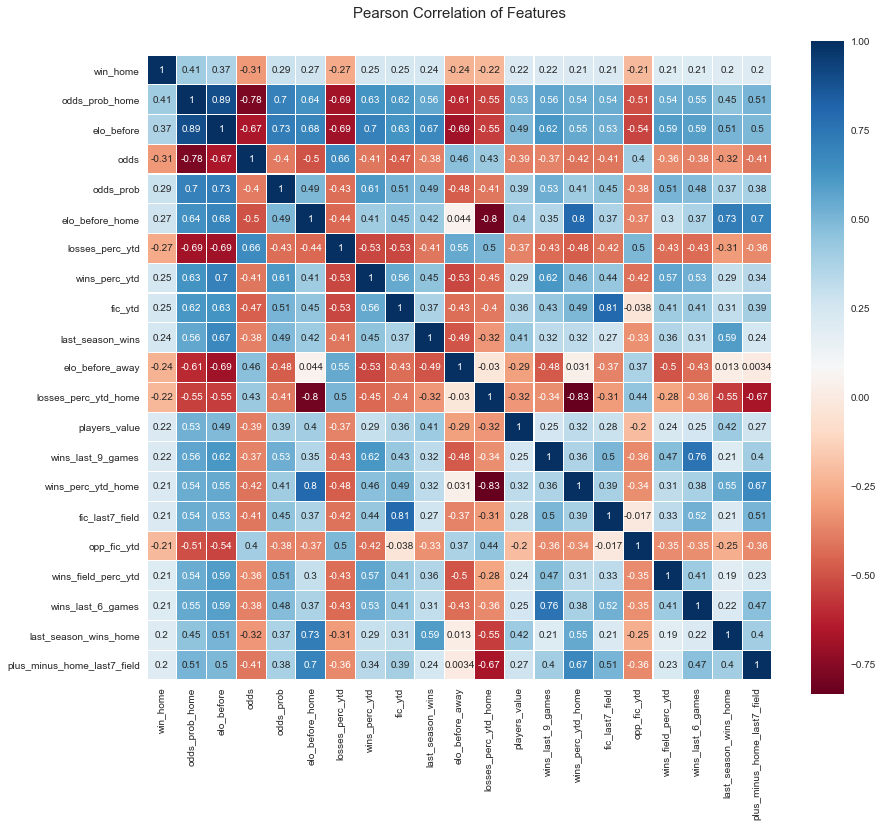

In [18]:
# heatmap with person correlation of features using 20 field more correlated with the target variable
top20 = data_selected.apply(lambda x: x.corr(data_selected.win_home)).abs().to_frame().\
                        sort_values(by=0, ascending=False).head(21)
top20 = top20.index.values.tolist()
all_data = data[top20]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(all_data.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### CREATE & TUNE MODEL

Hyperparameter Tune with GridSearchCV

In [18]:
# algorithms
vote_est = [
    # ensemble methods: 
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
        
    # xgboost:
    ('xgb', XGBClassifier()),
       
    # neural network
    ('mlp', MLPClassifier()),
    
    # linear: 
    ('lr', linear_model.LogisticRegressionCV()),
    ('sgd', linear_model.SGDClassifier()),
    
    # KNN
    ('knn', neighbors.KNeighborsClassifier()),
    
    # SVM
    ('svc', svm.SVC()),
    
    # decision tree
    ('tree', tree.DecisionTreeClassifier()) 
    ]

# parameters
grid_n_estimator = [10, 50, 100, 300, 500]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .05, .1, .25, 0.5, 1]
grid_max_depth = [2, 5, 10, 15, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
    
            [{
            #AdaBoost
            'n_estimators': grid_n_estimator, #default=10
            'learning_rate': grid_learn, #default=1.0
            'random_state': grid_seed
            }],


            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
             'random_state': grid_seed
             }],
    
            [{
            #xgboost - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
            'eta': [0.15], #default=10
            'min_child_weight': [1,3,5], #default=”gini”
            'subsample': [0.7,0.85,1], #default=”gini”
            'max_depth':  [2,5,8,10], #default=None
            'seed': grid_seed
            }],

         
            [{
            #MLP 
            'hidden_layer_sizes': [(10,),(50,),(100,), (250,)], #default=10
            'activation': ['relu','logistic'],
            'solver': ['adam','lbfgs'],
            'random_state': grid_seed
            }],

    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True              
            'Cs': [1,10,50],  
            'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
        
            [{
            #sgd - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'loss': ['hinge', 'modified_huber', 'squared_hinge'], #default: True
            'penalty': ['l1','l2'],               
            'random_state': grid_seed
             }],
            
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [3,5,10,15,50], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size':[10,30,50]
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'random_state': grid_seed
             }],

            [{
            #tree
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }]
            ]

# function to retrieve the best parameters
def parameters(X, y):
    start_total = time.perf_counter()
    for clf, param in zip (vote_est, grid_param):

        start = time.perf_counter()        
        best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, scoring = 'accuracy')
        best_search.fit(X, y)
        run = time.perf_counter() - start

        best_param = best_search.best_params_
        print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
        clf[1].set_params(**best_param) 

    run_total = time.perf_counter() - start_total
    print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

    print('-'*10)

Machine Learning Algorithm (MLA) selection and initialization

In [48]:
# split dataset in cross-validation with this splitter class
# run model 10x with 70/25 split intentionally leaving out 5%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .25, train_size = .7, random_state = 0) 


# evaluation methods
scoring = { 'acc': 'accuracy',
            'prec_macro': 'precision_macro',
            'rec_micro': 'recall_macro',
            'f1': 'f1',
            'roc':'roc_auc'}

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 
               'MLA Test Accuracy 3*STD' ,'MLA Time']

# function to predict the results
def model(X, y, probabilty = False):
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    # create table to compare MLA predictions
    MLA_predict = pd.DataFrame()
    MLA_prob = pd.DataFrame()
    
    # index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        # set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        # score model with cross validation
        cv_results = model_selection.cross_validate(alg, X, y, cv = cv_split, scoring = scoring, return_train_score=True)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_acc'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_acc'].mean()   
        # if this is a non-bias random sample, then +/-3 std from the mean should capture 99.7% of the subsets
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_acc'].std()*3

        # save MLA predictions and probabilities
        MLA_predict[MLA_name] = model_selection.cross_val_predict(alg, X, y)  
        
        if probabilty:
            MLA_prob[MLA_name] = model_selection.cross_val_predict(alg, X, y.values.ravel(), method='predict_proba')[:,1]    

        row_index+=1
    
    # return dfs
    if probabilty:
        return MLA_compare, MLA_predict, MLA_prob
    else:
        return MLA_compare, MLA_predict

In [20]:
# same for all models
y = data[target]
scaler = MinMaxScaler()

##### MODEL #1 - Top variables 

In [49]:
# select only 50 fields more correlated with target variable
fields = data_selected.apply(lambda x: x.corr(data_selected.win_home)).abs().to_frame()\
                        .sort_values(by=0, ascending=False).head(51)
fields = fields.index.values.tolist()
X = data[fields].drop('win_home',axis=1)
X = X.fillna(1)
X = X.replace([np.inf, np.NINF], 2)

# normalize the data
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [23]:
parameters(X, y)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.5, 'n_estimators': 10, 'random_state': 0} with a runtime of 973.22 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 4835.75 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 10, 'random_state': 0} with a runtime of 1314.98 seconds.
The best parameter for XGBClassifier is {'eta': 0.15, 'max_depth': 2, 'min_child_weight': 1, 'seed': 0, 'subsample': 0.85} with a runtime of 182.08 seconds.
The best parameter for MLPClassifier is {'activation': 'logistic', 'hidden_layer_sizes': (250,), 'random_state': 0, 'solver': 'adam'} with a runtime of 518.00 seconds.
The best parameter for LogisticRegressionCV is {'Cs': 50, 'fit_intercept': False, 'random_state': 0, 'solver': 'saga'} with a runtime of 1610.27 seconds.
The best parameter for SGDClassifier is {'loss': 'hinge', 'penalty': 'l1', 

In [52]:
# Machine Learning Algorithm (MLA) parameters from the results of the parameters function

MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(learning_rate= 0.5, n_estimators= 10),
    ensemble.BaggingClassifier(max_samples=0.25, n_estimators= 300),
    ensemble.RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=10),
    
    # xgboost
    XGBClassifier(eta= 0.15, max_depth= 2, min_child_weight= 1, subsample= 0.85),  
    
    # neural network
    MLPClassifier(activation= 'logistic', hidden_layer_sizes= (250,), solver= 'adam'),
    
    # linear
    linear_model.LogisticRegressionCV(Cs= 50, fit_intercept= False, solver= 'saga'),
    linear_model.SGDClassifier(loss= 'hinge', penalty= 'l1'),

    # KNN
    neighbors.KNeighborsClassifier(algorithm= 'auto', leaf_size= 10, n_neighbors= 50, weights= 'uniform'),
    
    # SVM
    svm.SVC(C= 4, decision_function_shape= 'ovo', kernel= 'linear'),
    
    # decion trees    
    tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 2)
    ]

In [53]:
comparison1, predict1 = model(X, y)

##### MODEL #2 - Four Factors

In [55]:
# select fields
X = data[four_factors_ratio]
X = X.fillna(1)
X = X.replace([np.inf, np.NINF], 2)

# normalize the data
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [27]:
parameters(X, y)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 0} with a runtime of 647.62 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.1, 'n_estimators': 500, 'random_state': 0} with a runtime of 970.41 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500, 'random_state': 0} with a runtime of 919.67 seconds.
The best parameter for XGBClassifier is {'eta': 0.15, 'max_depth': 2, 'min_child_weight': 5, 'seed': 0, 'subsample': 1} with a runtime of 102.60 seconds.
The best parameter for MLPClassifier is {'activation': 'logistic', 'hidden_layer_sizes': (250,), 'random_state': 0, 'solver': 'adam'} with a runtime of 512.26 seconds.
The best parameter for LogisticRegressionCV is {'Cs': 50, 'fit_intercept': False, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 164.69 seconds.
The best parameter for SGDClassifier is {'loss': 'hinge', 'penalty': 'l1', 

In [56]:
# Machine Learning Algorithm (MLA) parameters from the results of the parameters function

MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(learning_rate= 0.5, n_estimators= 50),
    ensemble.BaggingClassifier(max_samples=0.1, n_estimators= 500),
    ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500),
    
    # xgboost
    XGBClassifier(eta= 0.15, max_depth= 2, min_child_weight= 5, subsample= 1),  
    
    # neural network
    MLPClassifier(activation= 'logistic', hidden_layer_sizes= (250,), solver= 'adam'),
    
    # linear
    linear_model.LogisticRegressionCV(Cs= 50, fit_intercept= False, solver= 'liblinear'),
    linear_model.SGDClassifier(loss= 'hinge', penalty= 'l1'),

    # KNN
    neighbors.KNeighborsClassifier(algorithm= 'auto', leaf_size= 30, n_neighbors= 50, weights= 'uniform'),
    
    # SVM
    svm.SVC(C= 5, decision_function_shape= 'ovo', kernel= 'linear'),
    
    # decion trees      
    tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 5)
    ]

In [57]:
comparison2, predict2 = model(X, y)

##### MODEL #3 - PREGAME

In [58]:
# select fields
X = data[pregame]
X = X.fillna(1)
X = X.replace([np.inf, np.NINF], 2)

# normalize the data
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [34]:
parameters(X, y)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 0} with a runtime of 809.59 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.1, 'n_estimators': 500, 'random_state': 0} with a runtime of 1652.49 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'random_state': 0} with a runtime of 843.89 seconds.
The best parameter for XGBClassifier is {'eta': 0.15, 'max_depth': 2, 'min_child_weight': 3, 'seed': 0, 'subsample': 0.7} with a runtime of 118.18 seconds.
The best parameter for MLPClassifier is {'activation': 'logistic', 'hidden_layer_sizes': (250,), 'random_state': 0, 'solver': 'lbfgs'} with a runtime of 750.71 seconds.
The best parameter for LogisticRegressionCV is {'Cs': 50, 'fit_intercept': True, 'random_state': 0, 'solver': 'lbfgs'} with a runtime of 754.04 seconds.
The best parameter for SGDClassifier is {'loss': 'hinge', 'penalty': 'l1', 'rand

In [59]:
# Machine Learning Algorithm (MLA) parameters from the results of the parameters function

MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(learning_rate= 0.1, n_estimators= 100),
    ensemble.BaggingClassifier(max_samples=0.1, n_estimators= 500),
    ensemble.RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=50),
    
    # xgboost
    XGBClassifier(eta= 0.15, max_depth= 2, min_child_weight= 3, subsample= 0.7),  
    
    # neural network
    MLPClassifier(activation= 'logistic', hidden_layer_sizes= (250,), solver= 'lbfgs'),
    
    # linear
    linear_model.LogisticRegressionCV(Cs= 50, fit_intercept= True, solver= 'lbfgs'),
    linear_model.SGDClassifier(loss= 'hinge', penalty= 'l2'),

    # KNN
    neighbors.KNeighborsClassifier(algorithm= 'auto', leaf_size= 10, n_neighbors= 50, weights= 'distance'),
    
    # SVM
    svm.SVC(C= 5, decision_function_shape= 'ovo', kernel= 'linear'),
    
    # decion trees  
    tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 2)
    ]

In [60]:
comparison3, predict3 = model(X, y)

##### MODEL #4 - SCORING + STATS

In [61]:
# select fields
X = data[advanced_stats_ratio+scoring_ratio]
X = X.fillna(1)
X = X.replace([np.inf, np.NINF], 2)

# normalize the data
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [38]:
parameters(X, y)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 0} with a runtime of 1379.34 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 2916.94 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'random_state': 0} with a runtime of 1315.32 seconds.
The best parameter for XGBClassifier is {'eta': 0.15, 'max_depth': 2, 'min_child_weight': 5, 'seed': 0, 'subsample': 1} with a runtime of 140.73 seconds.
The best parameter for MLPClassifier is {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'random_state': 0, 'solver': 'adam'} with a runtime of 519.79 seconds.
The best parameter for LogisticRegressionCV is {'Cs': 10, 'fit_intercept': True, 'random_state': 0, 'solver': 'saga'} with a runtime of 741.44 seconds.
The best parameter for SGDClassifier is {'loss': 'hinge', 'penalty': 'l1', 'random

In [62]:
# Machine Learning Algorithm (MLA) parameters from the results of the parameters function

MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(learning_rate= 0.01, n_estimators= 50),
    ensemble.BaggingClassifier(max_samples=0.25, n_estimators= 300),
    ensemble.RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=100),
    
    # xgboost
    XGBClassifier(eta= 0.15, max_depth= 2, min_child_weight= 5, subsample= 1),  
    
    # neural network
    MLPClassifier(activation= 'logistic', hidden_layer_sizes= (10,), solver= 'adam'),
    
    # linear
    linear_model.LogisticRegressionCV(Cs= 10, fit_intercept= True, solver= 'saga'),
    linear_model.SGDClassifier(loss= 'hinge', penalty= 'l1'),

    # KNN
    neighbors.KNeighborsClassifier(algorithm= 'auto', leaf_size= 10, n_neighbors= 50, weights= 'uniform'),
    
    # SVM
    svm.SVC(C= 2, decision_function_shape= 'ovo', kernel= 'linear'),
    
    # decion trees   
    tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 5)
    ]

In [63]:
comparison4, predict4 = model(X, y)

#### SECOND LEVEL STACKING

In [64]:
# create X joining the results of all previous models
X = predict1.add_prefix('m1_').join(predict2.add_prefix('m2_'))\
    .join(predict3.add_prefix('m3_')).join(predict4.add_prefix('m4_'))

In [65]:
# using only bagging, because it is better for predictions
vote_est = [('bc', ensemble.BaggingClassifier())]

grid_param = [[{
            'n_estimators': grid_n_estimator,
            'max_samples': grid_learn, 
            'max_features': grid_learn,
            'bootstrap': grid_bool, 
            'bootstrap_features': grid_bool, 
            'random_state': grid_seed
             }]]

parameters(X, y)

The best parameter for BaggingClassifier is {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.25, 'max_samples': 0.5, 'n_estimators': 500, 'random_state': 0} with a runtime of 1807.30 seconds.
Total optimization time was 30.12 minutes.
----------


In [66]:
# Machine Learning Algorithm (MLA) parameters from the results of the parameters function

MLA = [ensemble.BaggingClassifier(max_samples=0.5, n_estimators= 500, bootstrap=True,
                                  bootstrap_features=False, max_features=0.5),]

In [67]:
comparison_final, predict_final, prob_final = model(X, y, probabilty=True)

Feature selection

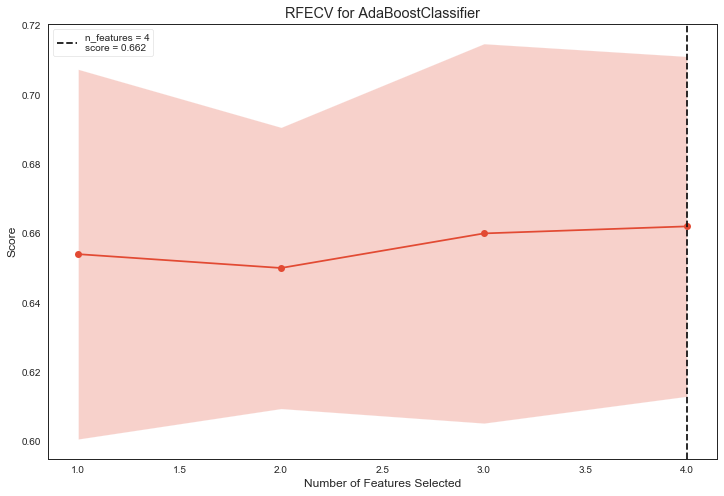

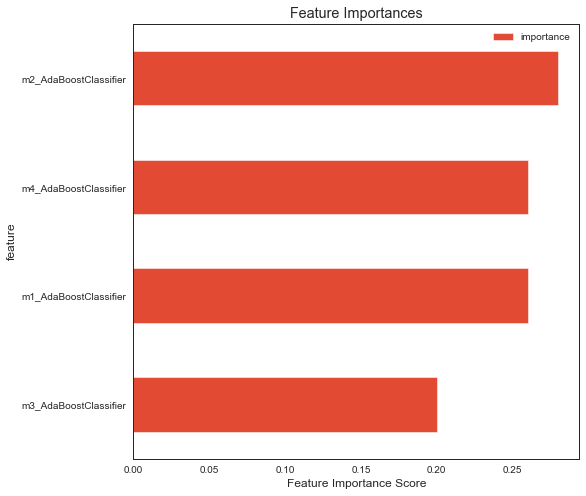

Model: AdaBoostClassifier
Optimal number of features: 4
Best features: Index(['m1_AdaBoostClassifier', 'm2_AdaBoostClassifier',
       'm3_AdaBoostClassifier', 'm4_AdaBoostClassifier'],
      dtype='object')


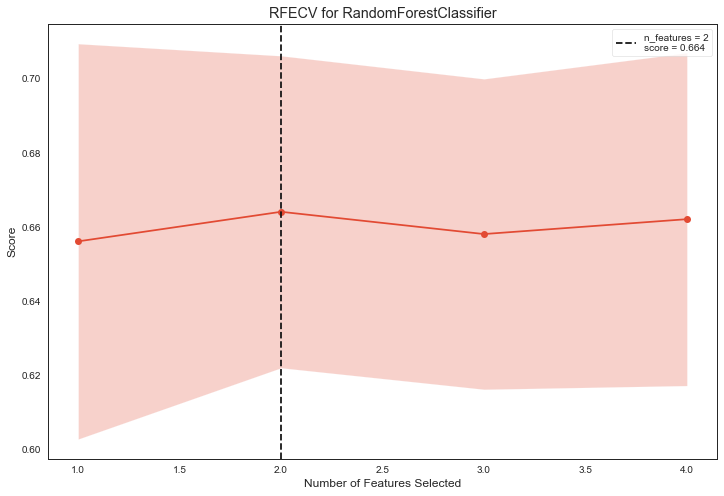

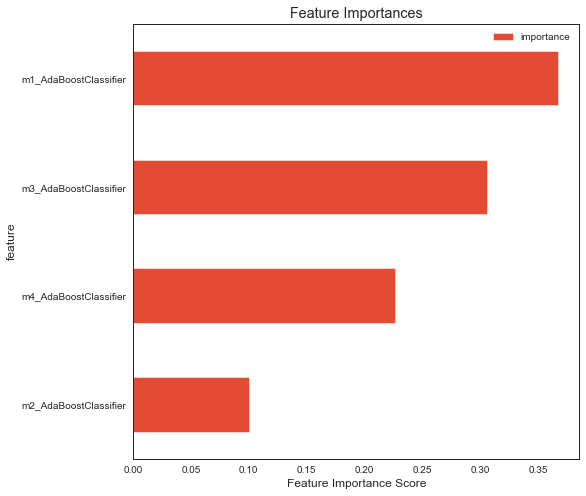

Model: RandomForestClassifier
Optimal number of features: 2
Best features: Index(['m1_AdaBoostClassifier', 'm3_AdaBoostClassifier'], dtype='object')


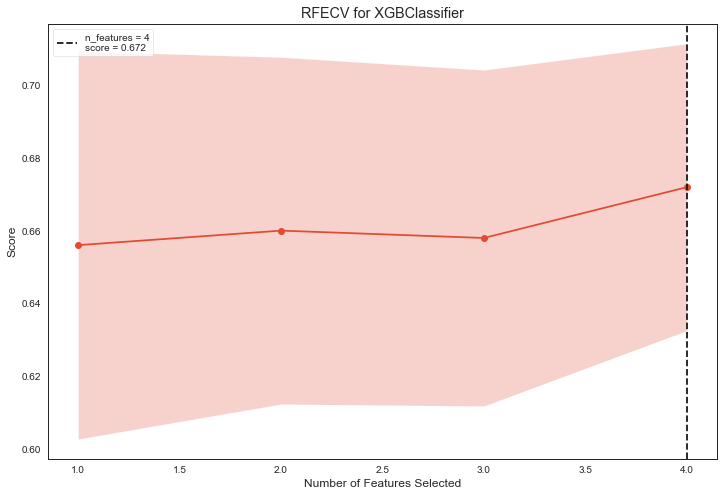

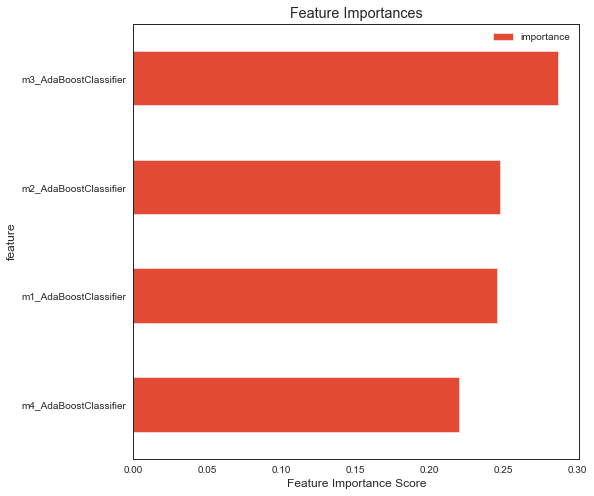

Model: XGBClassifier
Optimal number of features: 4
Best features: Index(['m1_AdaBoostClassifier', 'm2_AdaBoostClassifier',
       'm3_AdaBoostClassifier', 'm4_AdaBoostClassifier'],
      dtype='object')


In [43]:
# recursive feature selection and feature importance
# just for model 1 (presentation purposes)
# must define X for model 1 again

def plot_feature_importances(clf, X_train, y_train = None, top_n = 10, 
                             figsize = (8,8), print_table = False, title = "Feature Importances"):
    ''' 
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False

    '''
    __name__ = "plot_feature_importances"
    

    from xgboost.core import XGBoostError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            

    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(learning_rate= 0.25, n_estimators= 50),
    ensemble.RandomForestClassifier(criterion='gini', max_depth=2, n_estimators=10),
    
    # xgboost
    XGBClassifier(eta= 0.15, max_depth= 2, min_child_weight= 3, subsample= 0.7),  
    ]

row_index = 0
for alg in MLA:

    # set name and parameters
    MLA_name = alg.__class__.__name__
    
    # score model with cross validation
    rfecv = RFE(alg, step=1, cv=3, scoring='accuracy')   #3-fold cross-validation
    rfecv = rfecv.fit(X, y)
    rfecv.poof()
    
    plot_feature_importances(alg, X, y)

    
    print('Model:', MLA_name)
    print('Optimal number of features:', rfecv.n_features_)
    print('Best features:', X.columns[rfecv.support_])
    
    row_index+=1